In [198]:
# Cluster via K Means, DBSCAN, Spectral Clustering

In [199]:
# Graph and save V-measure, ARI, Adjusted Mutual Informatio

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
import csv
import pandas as pd
from pandas import DataFrame
def load_data(file_name: str = "Data.csv" , debug: bool = False ) -> DataFrame:
    
    try:
        with open(file_name, mode ='r')as file:
            csv_file = csv.reader(file)
        df = pd.read_csv(file_name)
        if debug:
            print("Dataframe after loading data")
            print(df.head(5))
    except:
        print("Could Not Load File")
   
    if debug:
        print("Loading Data Completed")
    return df

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import RobustScaler
import numpy as np
# Vectorizing Method: 
def vectorize_data(df, v_method: int = 0, debug:bool = False) -> DataFrame:
    
    all_vectorized_dfs = []

    # Iterate over each column except the first one
    for column in df.columns[3:]:
        if v_method == 0:
            vectorizer = TfidfVectorizer(stop_words='english')
        elif v_method == 1:
            vectorizer = CountVectorizer(stop_words='english')

        else:
            raise ValueError(f"Vectorizing method '{v_method}' is not supported.")
        transformed_data = vectorizer.fit_transform(df[column].values.astype('U'))

        if debug:
            print(f"Shape after vectorizing column '{column}':", transformed_data.shape)

        # Convert the sparse matrix to a DataFrame
        vectorized_df = pd.DataFrame(transformed_data.toarray(), columns=[f"{column}_{feature}"
                        for feature in vectorizer.get_feature_names_out()])
        all_vectorized_dfs.append(vectorized_df)


    # Concatenate all the vectorized DataFrames along the columns
    df_vectorized = pd.concat(all_vectorized_dfs, axis=1)

    # Append the first column of the original DataFrame
    df_combined = pd.concat([df.iloc[:, [0]], df_vectorized], axis=1)

    if debug:
        print("Final DataFrame shape after vectorizing all columns:", df_final.shape)
    df_combined = df_combined.replace([np.inf, -np.inf], np.nan)
    df_filled = df_combined.fillna(-1)
    df_names = df_filled.drop("Character",axis='columns')
    df_filled.drop("Character",axis='columns', inplace=True)
    # Fit and transform the data
    scaler = RobustScaler()
    scaled_data = scaler.fit_transform(df_filled)

    # Convert the scaled data back to a DataFrame
    df_final = pd.DataFrame(scaled_data, columns=df_filled.columns)
    return df_final,df_names


In [27]:
import pandas as pd
from sklearn.decomposition import PCA, FastICA, KernelPCA
from sklearn.neural_network import BernoulliRBM
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score, silhouette_score,calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns

def data_reduction(file_name: str,df: pd.DataFrame, method: int = 0, 
                   clusters: int = 3,v_ind: int = 0, debug: bool = False) -> pd.DataFrame:
    if debug:
        print("Starting data reduction")
    temp_df = df
    char_names = df.drop(df.columns[0], axis=1, inplace=True)
    #print(char_names)
    #print(temp_df.head(5))
    # Select the reduction method
    if v_ind:
        vector = "CountVectorizer"
    else:
        vector = "TfidfVectorizer"
        
    if method == 0:
        reduced_data = df 
        reduction_method = "Raw"
    elif method == 1:
        reducer = PCA(n_components=2)
        reduction_method = "PCA"
    elif method == 2:
        reducer = FastICA(n_components=2)
        reduction_method = "ICA"
    elif method == 3:
        reducer = KernelPCA(n_components=2, kernel='rbf')
        reduction_method = "KernelPCA"
    elif method == 4:
        reducer = BernoulliRBM(n_components=2,)
        reduction_method = "RBM"
    elif method == 5:
        feats = len(df.columns)
        layer_one = round(feats,2)
        if debug:
            print(f"Layer Size: {layer_one}")
        reducer = BernoulliRBM(n_components=layer_one, n_iter=50, learning_rate=0.01)
        reducer = BernoulliRBM(n_components=2,n_iter=50, learning_rate=0.01)
        reduction_method = "Double-RBM"
    else:
        raise ValueError("Unknown reduction method specified")
    if method != 0:
        # Apply the reduction
        reduced_data = reducer.fit_transform(temp_df)
    
    if debug:
        print(f"Reduction method: {reduction_method}")
        print("Reduced data shape:", reduced_data.shape)
    
    # Perform clustering
    clustering_algorithms = {
        #'K-Means': KMeans(n_clusters=clusters, random_state=42,n_init='auto'),
        #'Spectral': SpectralClustering(n_clusters=clusters, random_state=42, affinity='nearest_neighbors'),
        'Agglomerative Clustering':  AgglomerativeClustering(n_clusters=clusters)
    }

    evaluations = []

    for name, algorithm in clustering_algorithms.items():
        labels = algorithm.fit_predict(reduced_data)
        print(f"Clustering method: {name}")
        new_file_str = f"d_{file_name} v_{vector} m_{reduction_method} c_{clusters}"
        temp_df[f'Cluster_{name}'] = labels
        temp_df.to_csv(f"data {new_file_str}.csv")
        sil, cal_hara,davies = evaluate_clustering(temp_df, labels)
        evaluations.append((file_name,vector,reduction_method, name,clusters, sil, cal_hara,davies))
        
        if method != 0:
            # Plotting the clustered data
            plt.figure(figsize=(10, 6))
            plt.suptitle(f"Decomposed and Clustered Data")
            plt.title(f"File:{file_name}|Reduction:{reduction_method}|Method:{name}|Clusters:{clusters}")
            sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=labels, palette='viridis', s=100, alpha=0.7)
            plt.xlabel("Component 1")
            plt.ylabel("Component 2")
            plt.legend(title='Cluster')
            plt.savefig(f"Graph {new_file_str}.jpg", dpi=450)
            if debug:
                plt.show()
    

   
    return evaluations

def evaluate_clustering(x, y):
    # Shuffle the y labels to create random labels
    shuffled_labels = np.random.permutation(y)
    
    # Compute silhouette score with the provided labels
    sil = silhouette_score(x, y)
    cal_hara = calinski_harabasz_score(x,y)
    davies =davies_bouldin_score(x,y)
    
    return sil, cal_hara,davies


In [28]:
def __main__(file_name: str = "data.csv",debug: bool = False)-> int:
    df = load_data(file_name,False)
    v = [0]
    r = [1]
    clusters = [5]
    results = []
    for v_ind in v:
        v_df,names = vectorize_data(df,v_ind,False)
        for red_ind in r:
            for c in clusters:
                test_results = data_reduction(file_name[:-4],v_df,red_ind,c,v_ind,False)
                for t in test_results:
                    results.append(t)
    final_results = pd.DataFrame(results,columns=["Dataset", "v_ind","Reduction_method","Clustering Method", "Clusters", "Sil Score", " Cal Hara", "Davies"])
    final_results.to_csv(f"{file_name[:-4]} Test Results.csv")
    return 1;

Clustering method: Agglomerative Clustering


1

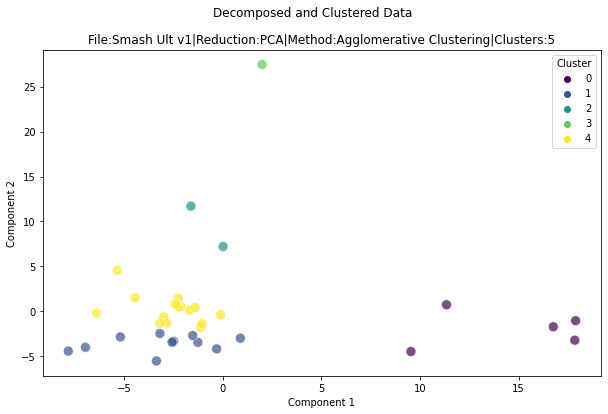

In [29]:
debug = True
__main__("Smash Ult v1.csv",debug)

### 